In [1]:
import ee
import os
import pandas as pd
import seaborn as sns
import geopandas as gpd
import geemap
import rasterio as rio
import pprint
import time
import gc
import numpy as np

from sklearn.preprocessing import Normalizer
from numpy import unique
from rasterio import features
from osgeo import gdal
from osgeo import osr
from datetime import datetime
from dateutil import relativedelta
from datetime import timedelta



In [2]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [3]:
x = '-55.31266378147653,-7.81758568042511,\
  -54.15909932835153,-7.81758568042511,\
  -54.15909932835153,-6.705986623490198,\
  -55.31266378147653,-6.705986623490198,\
  -55.31266378147653,-7.81758568042511'
x = x.split(',')
x = [[float(x[i]), float(x[i+1])] for i in range(0,len(x),2)]


geometria = geometry = ee.Geometry.Polygon(x)

# Definição dos clusters
 - Obteção dos clusters;
 - Criação de mascara para cada cluster obtido;
 - Visualização das mascaras.

In [4]:
# Dataset 
image = ee.ImageCollection("LANDSAT/LC08/C02/T1_RT")\
  .filterBounds(geometry)\
  .filter(ee.Filter.lt('CLOUD_COVER', 5))\
  .filterDate('2012-01-01', '2022-01-01')\
  .median()\
  .clip(geometria)

# Create NDVI index
ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')

# Add NDVI to the image
image = image.addBands(ndvi)

bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI']

image = image.select(bands)
# Select all bands and NDVI for the classification
#print(image.bandNames().getInfo())


# Perform K-means clustering
training_dataset = image.sample(
    **{
        'scale': 30,
        'numPixels': 2000,
        'seed': 0,
        'geometries': True,  # Set this to False to ignore geometries
    }
)


clusters_kmeans = ee.Clusterer.wekaKMeans(9).train(training_dataset)

# Classify the image
classified = image.cluster(clusters_kmeans)

# Create a mask for each of the 8 clusters
mask0 = classified.eq(0)
mask1 = classified.eq(1)
mask2 = classified.eq(2)
mask3 = classified.eq(3)
mask4 = classified.eq(4)
mask5 = classified.eq(5)
mask6 = classified.eq(6)
mask7 = classified.eq(7)
mask8 = classified.eq(8)

In [5]:
# Create a default map
Map = geemap.Map()

#Create an NDWI image, define visualization parameters and display.
col = geemap.get_palette_colors(cmap_name='Dark2',  n_class=7)

masks = [mask0, mask1, mask2, mask3, mask4, mask5, mask6, mask7, mask8]

Map.setCenter(-54.36783956272653,-6.575035169457279,9)


Map.addLayer(image, {'bands':['B4','B3','B2']}, 'RGB')
Map.addLayer(classified.randomVisualizer(), {} , 'teste')
Map.addLayer(masks[0], {'palette': ['white', 'black']}, 'Cluster '+ str(0))
Map.addLayer(masks[1], {'palette': ['white', 'black']}, 'Cluster '+ str(1))
Map.addLayer(masks[2], {'palette': ['white', 'black']}, 'Cluster '+ str(2))
Map.addLayer(masks[3], {'palette': ['white', 'black']}, 'Cluster '+ str(3))
Map.addLayer(masks[4], {'palette': ['white', 'black']}, 'Cluster '+ str(4))
Map.addLayer(masks[5], {'palette': ['white', 'black']}, 'Cluster '+ str(5))
Map.addLayer(masks[6], {'palette': ['white', 'black']}, 'Cluster '+ str(6))
Map.addLayer(masks[7], {'palette': ['white', 'black']}, 'Cluster '+ str(7))
#Map.addLayer(mask0.randomVisualizer(), {} , 'mask')

# Display the map
Map

Map(center=[-6.575035169457279, -54.36783956272653], controls=(WidgetControl(options=['position', 'transparent…

# Definição das dimensões do ***espaço amostral $\Omega$***
*   **Dimensões**:

    * **Espacial**:
    
    ![DEU RUIM](ROI2.png "ROI").

    * **Temporal**: 2012-01-01  → 2022-01-01

*   **Dataset**: Landsat 8

    * **LANDSAT/LC08/C02/T1_RT**         
    

In [6]:
# Dataset 
IMAGE_COLLECTION = ee.ImageCollection("LANDSAT/LC08/C02/T1_RT")\
  .filterBounds(geometry)\
  .filter(ee.Filter.lt('CLOUD_COVER', 10))\
  .filterDate('2019-11-11', '2022-01-01')





masked = IMAGE_COLLECTION.map(lambda img: img.updateMask(mask0))

Map = geemap.Map()
Map.addLayer(masked.first().randomVisualizer(), {} , 'teste')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [7]:
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Jdate'] = pd.DatetimeIndex(df['Timestamp']).to_julian_date()
  return df


def fc_to_dict(fc):
  
  prop_names = fc.first().propertyNames()

  prop_lists = fc.reduceColumns(

      reducer=ee.Reducer.toList().repeat(prop_names.size()),

      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)


def create_reduce_region_function(geometry=masked.geometry(),
                                  reducer=ee.Reducer.median(),
                                  scale=30,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):

  def reduce_region_function(img):
    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

reduce_b = create_reduce_region_function(
    geometry=geometria, reducer=ee.Reducer.mean(), scale=30)

b_stat_fc = ee.FeatureCollection(IMAGE_COLLECTION.map(reduce_b)).filter(
    ee.Filter.notNull(IMAGE_COLLECTION.first().bandNames()))

dict = fc_to_dict(b_stat_fc).getInfo()
df = pd.DataFrame(dict)
df = add_date_info(df)
df.sample(5)

,B1,B10,B11,B2,B3,B4,B5,B6,B7,B8,...,QA_PIXEL,QA_RADSAT,SAA,SZA,VAA,VZA,millis,system:index,Timestamp,Jdate
33,9070.356186,26894.755133,24751.339317,8119.540869,7438.868292,6463.936095,16783.412938,9679.440906,6712.196863,7017.833813,...,21824.091717,0.0,4778.673565,3808.626864,-7921.669012,661.688757,1627566543075,LC08_227064_20210729,2021-07-29 13:49:03.075,2.459425e+06
0,9189.762099,26492.750454,24145.599850,8244.826956,7521.082001,6516.076336,16516.622252,10012.401659,6832.711761,7086.158096,...,21832.128186,0.0,4247.161745,4039.253800,10227.600339,610.421462,1591018964190,LC08_226065_20200601,2020-06-01 13:42:44.190,2.459002e+06
19,9611.140574,26682.244789,24345.611579,8702.398970,7993.826162,7041.687601,16453.839111,10216.865339,7138.426127,7576.081934,...,22148.419572,0.0,4163.139857,4221.444935,10169.017546,600.247231,1624196609536,LC08_226066_20210620,2021-06-20 13:43:29.536,2.459386e+06
6,11131.152009,28433.992849,26063.702872,10003.482341,8941.926580,7719.508922,19537.087662,11260.029391,7419.078930,8454.201359,...,21824.142332,0.0,6448.897589,3130.846551,10226.486360,608.560963,1599313405185,LC08_226065_20200905,2020-09-05 13:43:25.185,2.459098e+06
40,9129.552699,27773.555411,25400.151873,8188.579681,7550.368809,6604.569055,16204.680053,10288.547034,6991.661644,7134.227637,...,21825.033882,0.0,4225.463918,3880.923050,-7897.083773,453.202738,1622036946690,LC08_227065_20210526,2021-05-26 13:49:06.690,2.459361e+06


In [8]:
list_ic = masked.toList(masked.size())
print(list_ic)

ee.List({
  "functionInvocationValue": {
    "functionName": "Collection.toList",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.map",
          "arguments": {
            "baseAlgorithm": {
              "functionDefinitionValue": {
                "argumentNames": [
                  "_MAPPING_VAR_0_0"
                ],
                "body": {
                  "functionInvocationValue": {
                    "functionName": "Image.updateMask",
                    "arguments": {
                      "image": {
                        "argumentReference": "_MAPPING_VAR_0_0"
                      },
                      "mask": {
                        "functionInvocationValue": {
                          "functionName": "Image.eq",
                          "arguments": {
                            "image1": {
                              "functionInvocationValue": {
                                "function

In [9]:
list_ic = masked.toList(masked.size())
newList1 = ee.List([])
dateList = {}
testeDate = {}

Qdias = timedelta(days=30)

def di_to_array(di):
    
    di = di.values()
    di = list(di)
    di = np.array(di)
    
    return di

# Dataset 


for i in list(range(df.index.size)):

    if masked.size().getInfo()!=0:
        
        dateList[i] = df['Jdate'][i]

        blue = 'B2'; green = 'B3'; red = 'B4'; nir = 'B5'; swir1 = 'B6'; swir2 = 'B7';

        def ndvi(imagem):
            ndvi = imagem.expression('(nir - red) / (nir + red)',
            {
                'nir':imagem.select(nir),
                'red':imagem.select(red)
            }).rename('ndvi')
            return imagem.addBands(ndvi)

        def savi(imagem):
            savi = imagem.expression('((nir - red) / (nir + red + 0.5))*(1.5)',
            {
                'nir':imagem.select(nir),
                'red':imagem.select(red)
            }).rename('savi')
            return imagem.addBands(savi)


        masked = masked.map(ndvi)
        masked = masked.map(savi)
        mediana = masked.mean()
        media = masked.median()


        newList1 = newList1.add(mediana)
        newList1 = newList1.add(media)


In [10]:
def ext_lat_lon_pixel30(image, geometria, bandas):
    image = image.addBands(ee.Image.pixelLonLat())
    coordenadas = image.select(['longitude', 'latitude']+bandas).reduceRegion(reducer=ee.Reducer.toList(),geometry=geometria,scale=30,bestEffort=True)
    bandas_valores = []
    for banda in bandas:
        bandas_valores.append(np.array(ee.List(coordenadas.get(banda)).getInfo()).astype(float))

    return np.array(ee.List(coordenadas.get('latitude')).getInfo()).astype(float), np.array(ee.List(coordenadas.get('longitude')).getInfo()).astype(float), bandas_valores

In [11]:
dateList = di_to_array(dateList)
dateList1 = np.repeat(dateList,2)

In [12]:
dateList1.size

90

In [13]:
trainCollection = ee.ImageCollection(newList1)

In [14]:
defaultDummy = 0
df_ndvi = pd.DataFrame()
di = {}
index2 = list(range(0,90))#63
for j in range(trainCollection.size().getInfo()):
    tempndvi = index2[j]
    img = ee.Image(newList1.get(j))
    lat30, lon30, ind30 = ext_lat_lon_pixel30(img,geometria,['ndvi'])
    di[tempndvi] = ind30[0]
    
df_ndvi = df_ndvi.from_dict(di)
df_ndvi = df_ndvi.assign(Latitude = lat30)
df_ndvi = df_ndvi.assign(Longitude = lon30)
df_ndvi = df_ndvi.set_index(['Latitude','Longitude'])
df_ndvi.sample(10)

In [ ]:
print(f'Shape: {df_ndvi.shape}\n\n ------------------------------- \n\n col types: {df_ndvi.dtypes} \n\n \
       size: {IMAGE_COLLECTION.size().getInfo()}')

Shape: (244, 23)

 ------------------------------- 

 col types: B1                     float64
B10                    float64
B11                    float64
B2                     float64
B3                     float64
B4                     float64
B5                     float64
B6                     float64
B7                     float64
B8                     float64
B9                     float64
QA_PIXEL               float64
QA_RADSAT              float64
SAA                    float64
SZA                    float64
VAA                    float64
VZA                    float64
millis                   int64
ndvi                   float64
savi                   float64
system:index            object
Timestamp       datetime64[ns]
Jdate                  float64
dtype: object 

        size: 244


<AxesSubplot: xlabel='Timestamp', ylabel='ndvi'>

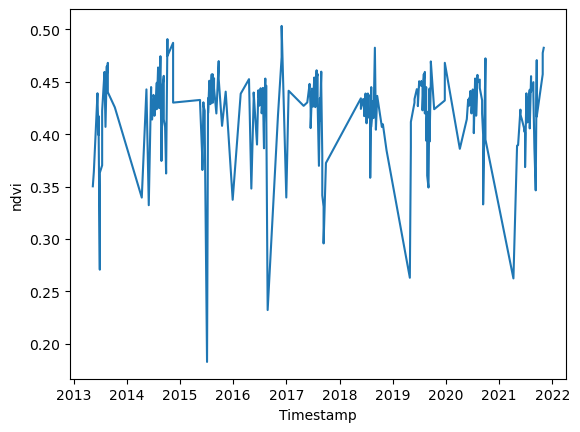

In [ ]:
sns.lineplot(y='ndvi',
             x='Timestamp',
             data=df)

In [ ]:
from sklearn.preprocessing import Normalizer
# %matplotlib inline: only draw static images in the notebook
subset = ['Timestamp','ndvi','savi','B2','B3','B4','B5']
df = df[subset]
norm = Normalizer()
normalizado = Normalizer().fit_transform(df[['ndvi','savi','B2','B3','B4','B5']].values)
padronizado = pd.DataFrame(normalizado)
padronizado_com_timestap = pd.concat([padronizado,df['Timestamp']],axis=1).rename(columns={i: subset[i] for i in range(0,len(subset))})
padronizado_com_timestap.sample(5)

,Timestamp,ndvi,savi,B2,B3,B4,Timestamp
58,0.000019,0.000028,0.405056,0.371165,0.326715,0.769041,2021-06-20 13:43:05.607
119,0.000021,0.000031,0.379816,0.348987,0.301447,0.801921,2019-08-02 13:43:41.616
240,0.000019,0.000029,0.392727,0.365262,0.328623,0.777404,2021-07-29 13:49:26.996
79,0.000016,0.000024,0.420568,0.387091,0.348493,0.742856,2015-06-04 13:42:48.057
177,0.000022,0.000032,0.379782,0.349086,0.303411,0.801153,2020-07-26 13:48:56.450


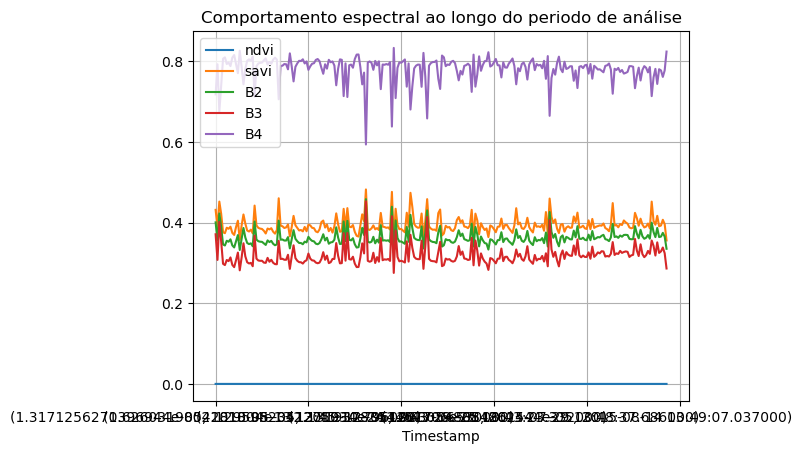

In [ ]:
ts_plot = padronizado_com_timestap.plot(x=0,
                     kind='line', \
                     title = 'Comportamento espectral ao longo do periodo de análise');
ts_plot.grid()
# define the legend location
ts_plot.legend(loc='upper left');

<AxesSubplot: xlabel='Timestamp', ylabel='ndvi'>

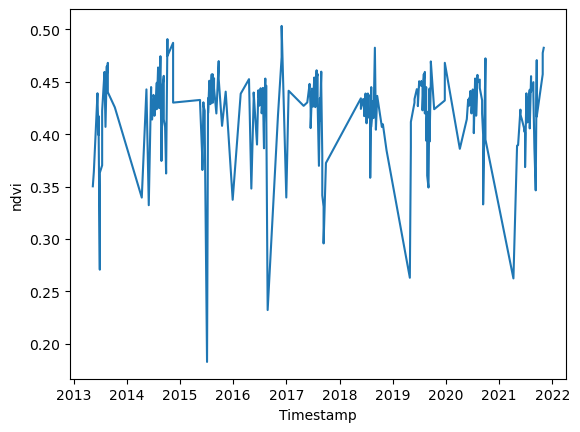

In [ ]:
sns.lineplot(y='ndvi',
            x='Timestamp',
            data=df)

In [ ]:
padronizado_com_timestap.to_csv('data_frame.csv')